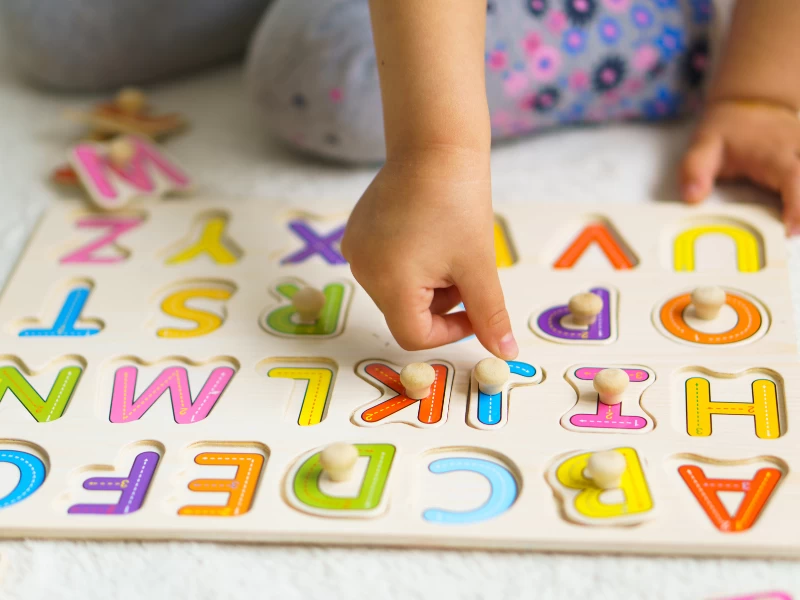


##  Data    
<a href="https://www.kaggle.com/datasets/nishan192/letterrecognition-using-svm">Kaggle</a>
    

## Objectives

After completing this lab you will be able to:

* Use <a href="https://snapml.readthedocs.io/en/latest/decision_trees.html">IBM snapML</a> algorithms to classify


## **Additional Information**

The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet.  The character images were based on 20 different fonts and each letter within these 20 fonts was randomly distorted to produce a file of 20,000 unique stimuli.  Each stimulus was converted into 16 primitive numerical attributes (statistical moments and edge counts) which were then scaled to fit into a range of integer values from 0 through 15.  We typically train on the first 16000 items and then use the resulting model to predict the letter category for the remaining 4000.  See the article cited above for more details.




<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the  data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


## import packages


In [4]:
#!pip install snapml

In [5]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, accuracy_score
%matplotlib inline 
import matplotlib.pyplot as plt

# dealing with imbalance classes
from imblearn.over_sampling import SMOTE
from collections import Counter

# suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data From CSV File  


In [6]:
letter_recognition = pd.read_csv("letter-recognition.csv")
letter_recognition.head()

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


## Basic EDA

In [7]:
# check the columns
letter_recognition.columns

Index(['letter', 'xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ',
       'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ',
       'xedgey', 'yedge ', 'yedgex'],
      dtype='object')

In [8]:
# data types
letter_recognition.dtypes

letter    object
xbox       int64
ybox       int64
width      int64
height     int64
onpix      int64
xbar       int64
ybar       int64
x2bar      int64
y2bar      int64
xybar      int64
x2ybar     int64
xy2bar     int64
xedge      int64
xedgey     int64
yedge      int64
yedgex     int64
dtype: object

In [9]:
# missing values
letter_recognition.isnull().sum()

letter    0
xbox      0
ybox      0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
x2ybar    0
xy2bar    0
xedge     0
xedgey    0
yedge     0
yedgex    0
dtype: int64

In [10]:
# value count of the churn to see if we are dealing with a balanced or unbalanced dataset
letter_recognition['letter'].value_counts()

U    813
D    805
P    803
T    796
M    792
A    789
X    787
Y    786
N    783
Q    783
F    775
G    773
E    768
B    766
V    764
L    761
R    758
I    755
O    753
W    752
S    748
J    747
K    739
C    736
H    734
Z    734
Name: letter, dtype: int64

In [11]:
# unique letters
letter_recognition['letter'].nunique()

26

## Data pre-processing and selection


In [12]:
feature_df = letter_recognition[['xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ',
       'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ',
       'xedgey', 'yedge ', 'yedgex']]
X = np.asarray(feature_df)
X[0:5]

array([[ 2,  8,  3,  5,  1,  8, 13,  0,  6,  6, 10,  8,  0,  8,  0,  8],
       [ 5, 12,  3,  7,  2, 10,  5,  5,  4, 13,  3,  9,  2,  8,  4, 10],
       [ 4, 11,  6,  8,  6, 10,  6,  2,  6, 10,  3,  7,  3,  7,  3,  9],
       [ 7, 11,  6,  6,  3,  5,  9,  4,  6,  4,  4, 10,  6, 10,  2,  8],
       [ 2,  1,  3,  1,  1,  8,  6,  6,  6,  6,  5,  9,  1,  7,  5, 10]],
      dtype=int64)

In [13]:
# label encode the column
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#letter_recognition['letter'] = le.fit_transform(letter_recognition['letter'])

# assign to the y variable
y = np.asarray(letter_recognition['letter'])
y [0:5]

array(['T', 'I', 'D', 'N', 'G'], dtype=object)

## Train/Test dataset


We split our dataset into train and test set:


In [14]:
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=10, stratify=y)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (16000, 16) (16000,)
Test set: (4000, 16) (4000,)


## Feature scaling


In [15]:
scaler = StandardScaler() # scaler objecy
x_train = scaler.fit_transform(x_train) # allow the scaler object to learn the features and transform the training data
x_test =  scaler.transform(x_test) # apply the learned features on the test set

In [16]:
# scaled x_train
x_train[0:2]

array([[ 1.02959671,  1.19334262,  1.42594162,  1.16054883,  0.68065974,
        -0.44200536, -0.64837588,  0.50794596,  0.76222057, -0.91637373,
        -0.17079137,  0.03726837, -0.01976787, -0.2197797 ,  0.12067208,
        -0.4938846 ],
       [-0.53682618, -0.61529462, -0.06109231,  1.16054883,  1.59437363,
         1.52396467,  1.07395245, -0.23206181, -1.3432157 , -1.71893433,
         0.58670327,  0.5181505 ,  0.40764556,  3.00397826,  0.90045934,
         0.12366413]])

In [17]:
# scaled x_test
x_test[0:2]

array([[-1.05896714, -1.82105279, -1.05244827, -1.49055617, -0.68991109,
         0.54097966, -0.2177938 ,  0.87794985,  0.76222057, -0.51509343,
         0.20795595, -1.88626016, -0.4471813 , -0.2197797 , -0.26922155,
        -1.11143334],
       [ 2.07387863,  0.289024  ,  0.43458567,  2.48610134,  0.68065974,
         0.04948715, -0.2177938 , -0.23206181, -0.92212845,  1.09002778,
        -0.17079137,  0.03726837, -0.01976787,  0.42497189,  2.8499275 ,
        -1.11143334]])

<div id="svm_snap">
    <h2>1.Build a Support Vector Machine model with Snap ML</h2>
</div>


In [18]:
# import the Support Vector Machine model (SVM) from Snap ML
from snapml import SupportVectorMachine

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of SVMs
# to use the GPU, set the use_gpu parameter to True
# snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
snapml_svm = SupportVectorMachine(kernel='rbf', random_state=25, n_jobs=4, fit_intercept=False)
# print(snapml_svm.get_params())

# train an SVM model using Snap ML
clf = snapml_svm.fit(x_train, y_train)

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Radial basis function (RBF)
   
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


After being fitted, the model can then be used to predict new values:


In [19]:
yhat = clf.predict(x_test)
yhat[0:5]

array(['V', 'J', 'I', 'Z', 'F'], dtype='<U21')

<h2 id="evaluation">Evaluation</h2>


In [20]:
from sklearn.metrics import classification_report

In [21]:
# classification report
print (classification_report(y_test, yhat,labels=np.unique(yhat)))

              precision    recall  f1-score   support

           A       0.16      0.05      0.08       158
           B       0.17      0.21      0.19       153
           C       0.27      0.18      0.22       147
           D       0.20      0.22      0.21       161
           E       0.19      0.11      0.14       154
           F       0.27      0.24      0.25       155
           G       0.20      0.20      0.20       155
           H       0.18      0.07      0.11       147
           I       0.20      0.60      0.30       151
           J       0.17      0.24      0.20       149
           K       0.20      0.11      0.14       148
           L       0.23      0.20      0.22       152
           M       0.26      0.15      0.19       158
           N       0.24      0.22      0.23       157
           O       0.21      0.50      0.30       151
           P       0.20      0.09      0.13       161
           Q       0.21      0.11      0.15       157
           R       0.20    

You can also easily use the __f1_score__ from sklearn library:


In [22]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.19797725859610474

In [23]:
SVM_rbf_f1 = f1_score(y_test, yhat, average='weighted')
SVM_rbf_accuracy = accuracy_score(y_test, yhat)

print("Avg F1-score: %.4f" % SVM_rbf_f1)
print("Accuracy: %.4f" % SVM_rbf_accuracy)

Avg F1-score: 0.1980
Accuracy: 0.2110


<h2 id="practice">Practice</h2>
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?


### Linear kernel

In [24]:
%%time
snapml_svm2 = SupportVectorMachine(kernel='linear', random_state=25, n_jobs=4, fit_intercept=False)
snapml_svm2.fit(x_train, y_train) 
yhat2 = snapml_svm2.predict(x_test)

CPU times: total: 3.38 s
Wall time: 4.6 s


In [25]:
# print the F1-score and accuracy_score
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Avg F1-score: %.4f" % accuracy_score(y_test, yhat2))

Avg F1-score: 0.4706
Avg F1-score: 0.4875


In [26]:
SVM_Linear_f1 = f1_score(y_test, yhat2, average='weighted')
SVM_Linear_f1_accuracy = accuracy_score(y_test, yhat2)

print("Avg F1-score: %.4f" % SVM_Linear_f1)
print("Accuracy: %.4f" % SVM_Linear_f1_accuracy)

Avg F1-score: 0.4706
Accuracy: 0.4875


In [27]:
# classification report
print (classification_report(y_test, yhat2,labels=np.unique(yhat2)))

              precision    recall  f1-score   support

           A       0.63      0.63      0.63       158
           B       0.41      0.65      0.50       153
           C       0.42      0.74      0.54       147
           D       0.93      0.39      0.55       161
           E       0.33      0.27      0.30       154
           F       0.40      0.70      0.51       155
           G       0.24      0.06      0.09       155
           H       0.38      0.16      0.22       147
           I       0.81      0.44      0.57       151
           J       0.31      0.72      0.44       149
           K       0.50      0.24      0.33       148
           L       0.48      0.70      0.57       152
           M       0.54      0.83      0.65       158
           N       0.72      0.31      0.43       157
           O       0.39      0.50      0.44       151
           P       0.83      0.61      0.71       161
           Q       0.44      0.63      0.52       157
           R       0.71    

<div id="svm_snap">
    <h2>2.Build a RandomForest model with Snap ML</h2>
</div>


In [28]:
%%time
# import the RandomForest from Snap ML
from snapml import RandomForestClassifier as SnapForest

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of RandomForest
# to use the GPU, set the use_gpu parameter to True
# rf = SnapForest(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
rf = SnapForest(n_estimators=10, criterion='gini', 
                            max_depth=20, min_samples_leaf=1, 
                            max_features='auto', bootstrap=True, 
                            n_jobs=1, random_state=None, verbose=False, 
                            use_histograms=False, hist_nbins=256, 
                            use_gpu=False, gpu_ids=[0], 
                            compress_trees=False)

# train an SVM model using Snap ML
clf = rf.fit(x_train, y_train)

CPU times: total: 156 ms
Wall time: 707 ms


After being fitted, the model can then be used to predict new values:


In [29]:
yhat3 = clf.predict(x_test)
yhat3[0:5]

array(['D', 'Z', 'E', 'Z', 'F'], dtype='<U32')

In [30]:
Random_f1 = f1_score(y_test, yhat3, average='weighted')
Random_accuracy = accuracy_score(y_test, yhat3)

print("Avg F1-score: %.4f" % Random_f1)
print("Accuracy: %.4f" % Random_accuracy)

Avg F1-score: 0.9388
Accuracy: 0.9387


<h2 id="evaluation">Evaluation</h2>


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [32]:
# classification report
print (classification_report(y_test, yhat3,labels=np.unique(yhat3)))

              precision    recall  f1-score   support

           A       0.97      0.97      0.97       158
           B       0.84      0.95      0.89       153
           C       0.96      0.93      0.94       147
           D       0.89      0.92      0.91       161
           E       0.93      0.90      0.91       154
           F       0.89      0.90      0.89       155
           G       0.92      0.95      0.93       155
           H       0.92      0.81      0.86       147
           I       0.95      0.96      0.96       151
           J       1.00      0.93      0.97       149
           K       0.94      0.92      0.93       148
           L       0.99      0.95      0.97       152
           M       0.96      0.96      0.96       158
           N       0.94      0.98      0.96       157
           O       0.89      0.90      0.90       151
           P       0.97      0.91      0.94       161
           Q       0.91      0.95      0.93       157
           R       0.89    

### 3. Boosting Machine Classifier

In [48]:
%%time
# import the BoostingMachineClassifier from Snap ML
from snapml import BoostingMachineClassifier as BoostMachine

Booting_clf = BoostMachine(n_jobs=1, num_round=100, max_depth=15, 
                                 min_max_depth=1, max_max_depth=5, early_stopping_rounds=10, 
                                 random_state=0, base_score=None, learning_rate=0.1, verbose=False, 
                                 compress_trees=False, class_weight=None, use_histograms=True, 
                                 hist_nbins=256, use_gpu=False, gpu_ids=[0], colsample_bytree=1.0,
                                 subsample=1.0, lambda_l2=0.0, 
                                 tree_select_probability=1.0, regularizer=1.0,
                                 fit_intercept=False, gamma=1.0, n_components=10)


Booting_clf.fit(x_train, y_train) 
yhat4 = Booting_clf.predict(x_test)

CPU times: total: 2min 14s
Wall time: 3min 8s


In [49]:
# print the F1-score and accuracy
Boosting_f1 = f1_score(y_test, yhat4, average='weighted')
Boosting_accuracy = accuracy_score(y_test, yhat4)

print("Avg F1-score: %.4f" % Boosting_f1)
print("Accuracy: %.4f" % Boosting_accuracy)

Avg F1-score: 0.9352
Accuracy: 0.9353


In [53]:
# classification report
print (classification_report(y_test, yhat4,labels=np.unique(yhat3)))

              precision    recall  f1-score   support

           A       0.99      0.97      0.98       158
           B       0.88      0.94      0.91       153
           C       0.97      0.95      0.96       147
           D       0.92      0.89      0.91       161
           E       0.93      0.91      0.92       154
           F       0.90      0.86      0.88       155
           G       0.87      0.95      0.91       155
           H       0.93      0.86      0.89       147
           I       0.94      0.99      0.96       151
           J       0.99      0.93      0.96       149
           K       0.96      0.92      0.94       148
           L       0.94      0.97      0.95       152
           M       0.94      0.95      0.94       158
           N       0.94      0.96      0.95       157
           O       0.91      0.92      0.91       151
           P       0.91      0.91      0.91       161
           Q       0.92      0.96      0.94       157
           R       0.89    

### **Report**

In [54]:
metric = {
  "Accuracy": [SVM_rbf_f1, SVM_Linear_f1, Random_f1, Boosting_f1],
  "F1 score" : [SVM_rbf_accuracy, SVM_Linear_f1_accuracy, Random_accuracy, Boosting_accuracy],
}


Report = pd.DataFrame(metric)
Report = Report.rename(index={0:'SVM rbf kernel- SnapML', 
                              1:'SVM linear kernel- SnapML', 
                              2:'Random Forest-SnapML', 
                              3:'Boosting Machine - SnapML'})

In [55]:
Report 

,Accuracy,F1 score
SVM rbf kernel- SnapML,0.197977,0.21100
SVM linear kernel- SnapML,0.470561,0.48750
Random Forest-SnapML,0.938810,0.93875
Boosting Machine - SnapML,0.935217,0.93525


### Thank you for completing this lab!

